In [2]:
import math
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Wedge
from dataclasses import dataclass
from typing import List, Tuple

In [3]:

@dataclass
class ShapeProperties:
    """Store calculated properties of a shape"""
    name: str
    area: float
    centroid_x: float
    centroid_y: float
    Ixx: float  # Moment of inertia about centroidal x-axis
    Iyy: float  # Moment of inertia about centroidal y-axis

class Shape:
    """Base class for all shapes"""
    def __init__(self, x: float, y: float, is_hollow: bool = False, angle: float = 0):
        self.x = x  # Position
        self.y = y
        self.is_hollow = is_hollow  # True means subtract this shape
        self.angle = angle  # Rotation angle in degrees
        self.properties = None
    
    def calculate_properties(self) -> ShapeProperties:
        """Calculate area, centroid, and moments of inertia"""
        raise NotImplementedError
    
    def rotate_point(self, px: float, py: float) -> Tuple[float, float]:
        """Rotate a point around the shape's reference point"""
        angle_rad = np.radians(self.angle)
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)
        
        # Translate to origin
        dx = px - self.x
        dy = py - self.y
        
        # Rotate
        rx = dx * cos_a - dy * sin_a
        ry = dx * sin_a + dy * cos_a
        
        # Translate back
        return self.x + rx, self.y + ry
    
    def rotate_moi(self, Ixx: float, Iyy: float) -> Tuple[float, float]:
        """Rotate moments of inertia - returns Ixx', Iyy' in global coordinates"""
        angle_rad = np.radians(self.angle)
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)
        
        # For principal axes, Ixy = 0, so simplified transformation
        Ixx_rot = Ixx * cos_a**2 + Iyy * sin_a**2
        Iyy_rot = Ixx * sin_a**2 + Iyy * cos_a**2
        
        return Ixx_rot, Iyy_rot
    
    def draw(self, ax):
        """Draw the shape on matplotlib axis"""
        raise NotImplementedError

class Rectangle_(Shape):
    def __init__(self, x: float, y: float, width: float, height: float, is_hollow: bool = False, angle: float = 0):
        super().__init__(x, y, is_hollow, angle)
        self.width = width
        self.height = height
    
    def calculate_properties(self) -> ShapeProperties:
        area = self.width * self.height
        Ixx_local = self.width * self.height**3 / 12  # About its own centroid
        Iyy_local = self.height * self.width**3 / 12
        
        # Local centroid
        cx_local = self.x + self.width / 2
        cy_local = self.y + self.height / 2
        
        # Rotate centroid
        cx, cy = self.rotate_point(cx_local, cy_local)
        
        # Rotate moments of inertia
        Ixx_rot, Iyy_rot = self.rotate_moi(Ixx_local, Iyy_local)
        
        self.properties = ShapeProperties(
            "Rectangle (Hollow)" if self.is_hollow else "Rectangle", 
            area, cx, cy, Ixx_rot, Iyy_rot
        )
        return self.properties
    
    def draw(self, ax):
        # Get corner points
        corners = np.array([
            [self.x, self.y],
            [self.x + self.width, self.y],
            [self.x + self.width, self.y + self.height],
            [self.x, self.y + self.height]
        ])
        
        # Rotate each corner
        rotated_corners = np.array([self.rotate_point(c[0], c[1]) for c in corners])
        
        if self.is_hollow:
            rect = Polygon(rotated_corners, fill=True, facecolor='white', 
                         edgecolor='red', linewidth=2, linestyle='--', hatch='///')
        else:
            rect = Polygon(rotated_corners, fill=True, facecolor='lightblue', 
                         edgecolor='blue', linewidth=2)
        ax.add_patch(rect)

class Circle_(Shape):
    def __init__(self, x: float, y: float, radius: float, is_hollow: bool = False, angle: float = 0):
        super().__init__(x, y, is_hollow, angle)
        self.radius = radius
    
    def calculate_properties(self) -> ShapeProperties:
        area = np.pi * self.radius**2
        Ixx_local = np.pi * self.radius**4 / 4  # About its own centroid
        Iyy_local = np.pi * self.radius**4 / 4
        
        # Circle centroid is at center (rotation doesn't change it for circles)
        cx = self.x
        cy = self.y
        
        # For circles, rotation doesn't affect MOI
        self.properties = ShapeProperties(
            "Circle (Hollow)" if self.is_hollow else "Circle", 
            area, cx, cy, Ixx_local, Iyy_local
        )
        return self.properties
    
    def draw(self, ax):
        if self.is_hollow:
            circle = Circle((self.x, self.y), self.radius, 
                          fill=True, facecolor='white', edgecolor='red', 
                          linewidth=2, linestyle='--', hatch='///')
        else:
            circle = Circle((self.x, self.y), self.radius, 
                          fill=True, facecolor='lightgreen', edgecolor='green', linewidth=2)
        ax.add_patch(circle)

class Semicircle(Shape):
    def __init__(self, x: float, y: float, radius: float, is_hollow: bool = False, angle: float = 0):
        super().__init__(x, y, is_hollow, angle)
        self.radius = radius
    
    def calculate_properties(self) -> ShapeProperties:
        area = np.pi * self.radius**2 / 2
        Ixx_local = 0.1098 * self.radius**4  # About centroidal axis
        Iyy_local = np.pi * self.radius**4 / 8
        
        # Centroid is at 4r/(3π) from base in local coordinates
        cy_offset = 4 * self.radius / (3 * np.pi)
        cx_local = self.x
        cy_local = self.y + cy_offset
        
        # Rotate centroid
        cx, cy = self.rotate_point(cx_local, cy_local)
        
        # Rotate moments of inertia
        Ixx_rot, Iyy_rot = self.rotate_moi(Ixx_local, Iyy_local)
        
        self.properties = ShapeProperties(
            "Semicircle (Hollow)" if self.is_hollow else "Semicircle", 
            area, cx, cy, Ixx_rot, Iyy_rot
        )
        return self.properties
    
    def draw(self, ax):
        # Create semicircle points
        theta = np.linspace(0, np.pi, 50)
        x_points = self.x + self.radius * np.cos(theta)
        y_points = self.y + self.radius * np.sin(theta)
        
        # Close the shape with base line
        x_points = np.append(x_points, self.x - self.radius)
        y_points = np.append(y_points, self.y)
        
        # Rotate all points
        points = np.column_stack([x_points, y_points])
        rotated_points = np.array([self.rotate_point(p[0], p[1]) for p in points])
        
        if self.is_hollow:
            wedge = Polygon(rotated_points, fill=True, facecolor='white', 
                          edgecolor='red', linewidth=2, linestyle='--', hatch='///')
        else:
            wedge = Polygon(rotated_points, fill=True, facecolor='lightcoral', 
                          edgecolor='red', linewidth=2)
        ax.add_patch(wedge)

class Triangle(Shape):
    def __init__(self, x: float, y: float, base: float, height: float, is_hollow: bool = False, angle: float = 0):
        super().__init__(x, y, is_hollow, angle)
        self.base = base
        self.height = height
    
    def calculate_properties(self) -> ShapeProperties:
        area = self.base * self.height / 2
        Ixx_local = self.base * self.height**3 / 36  # About centroidal axis
        Iyy_local = self.height * self.base**3 / 36
        
        # Centroid is at h/3 from base and b/2 from left edge (local)
        cx_local = self.x + self.base / 2
        cy_local = self.y + self.height / 3
        
        # Rotate centroid
        cx, cy = self.rotate_point(cx_local, cy_local)
        
        # Rotate moments of inertia
        Ixx_rot, Iyy_rot = self.rotate_moi(Ixx_local, Iyy_local)
        
        self.properties = ShapeProperties(
            "Triangle (Hollow)" if self.is_hollow else "Triangle", 
            area, cx, cy, Ixx_rot, Iyy_rot
        )
        return self.properties
    
    def draw(self, ax):
        verts = np.array([
            [self.x, self.y],
            [self.x + self.base, self.y],
            [self.x + self.base/2, self.y + self.height]
        ])
        
        # Rotate vertices
        rotated_verts = np.array([self.rotate_point(v[0], v[1]) for v in verts])
        
        if self.is_hollow:
            triangle = Polygon(rotated_verts, fill=True, facecolor='white', 
                             edgecolor='red', linewidth=2, linestyle='--', hatch='///')
        else:
            triangle = Polygon(rotated_verts, fill=True, facecolor='plum', 
                             edgecolor='purple', linewidth=2)
        ax.add_patch(triangle)

class CompositeShape:
    """Manage multiple shapes and calculate composite properties"""
    def __init__(self):
        self.shapes: List[Shape] = []
        self.composite_properties = None
    
    def add_shape(self, shape: Shape):
        """Add a shape to the composite"""
        self.shapes.append(shape)
        shape.calculate_properties()
    
    def calculate_composite_properties(self):
        """Calculate combined properties using parallel axis theorem"""
        if not self.shapes:
            print("No shapes added!")
            return None
        
        # Separate solid and hollow shapes
        solid_shapes = [s for s in self.shapes if not s.is_hollow]
        hollow_shapes = [s for s in self.shapes if s.is_hollow]
        
        # Calculate total area and first moment
        total_area = 0
        Qx = 0  # First moment about x-axis
        Qy = 0  # First moment about y-axis
        
        for shape in solid_shapes:
            props = shape.properties
            total_area += props.area
            Qx += props.area * props.centroid_y
            Qy += props.area * props.centroid_x
        
        for shape in hollow_shapes:
            props = shape.properties
            total_area -= props.area
            Qx -= props.area * props.centroid_y
            Qy -= props.area * props.centroid_x
        
        if total_area <= 0:
            print("Warning: Total area is zero or negative!")
            return None
        
        # Composite centroid
        cx_composite = Qy / total_area
        cy_composite = Qx / total_area
        
        # Calculate moment of inertia using parallel axis theorem
        # I = I_local + A*d^2
        Ixx_composite = 0
        Iyy_composite = 0
        
        for shape in solid_shapes:
            props = shape.properties
            dx = props.centroid_x - cx_composite
            dy = props.centroid_y - cy_composite
            Ixx_composite += props.Ixx + props.area * dy**2
            Iyy_composite += props.Iyy + props.area * dx**2
        
        for shape in hollow_shapes:
            props = shape.properties
            dx = props.centroid_x - cx_composite
            dy = props.centroid_y - cy_composite
            Ixx_composite -= (props.Ixx + props.area * dy**2)
            Iyy_composite -= (props.Iyy + props.area * dx**2)
        
        self.composite_properties = {
            'area': total_area,
            'centroid_x': cx_composite,
            'centroid_y': cy_composite,
            'Ixx': Ixx_composite,
            'Iyy': Iyy_composite
        }
        
        return self.composite_properties
    
    def visualize(self, show_centroids: bool = True):
        """Visualize all shapes with matplotlib"""
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Draw all shapes
        for shape in self.shapes:
            shape.draw(ax)
            
            # Draw individual centroids
            if show_centroids and shape.properties:
                marker_style = 'bx' if not shape.is_hollow else 'rx'
                ax.plot(shape.properties.centroid_x, shape.properties.centroid_y, 
                       marker_style, markersize=8, markeredgewidth=2, alpha=0.5)
        
        # Draw composite centroid
        if self.composite_properties:
            cx = self.composite_properties['centroid_x']
            cy = self.composite_properties['centroid_y']
            ax.plot(cx, cy, 'ko', markersize=12, label='_nolegend_', zorder=5)
            ax.plot(cx, cy, 'r+', markersize=18, markeredgewidth=3, 
                   label='Composite Centroid', zorder=5)
        
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.set_title('Composite Shape Visualization', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        plt.tight_layout()
        plt.show()
    
    def print_properties(self):
        """Print properties of individual shapes and composite"""
        print("\n" + "="*80)
        print("INDIVIDUAL SHAPE PROPERTIES")
        print("="*80)
        
        for i, shape in enumerate(self.shapes, 1):
            props = shape.properties
            sign = "SUBTRACTED" if shape.is_hollow else "ADDED"
            print(f"\nShape {i}: {props.name} [{sign}]")
            print(f"  Position: ({shape.x:.2f}, {shape.y:.2f})")
            print(f"  Rotation: {shape.angle:.1f}°")
            print(f"  Area: {props.area:.4f}")
            print(f"  Centroid: ({props.centroid_x:.4f}, {props.centroid_y:.4f})")
            print(f"  Ixx (local centroidal): {props.Ixx:.4f}")
            print(f"  Iyy (local centroidal): {props.Iyy:.4f}")
        
        if self.composite_properties:
            print("\n" + "="*80)
            print("COMPOSITE SHAPE PROPERTIES")
            print("="*80)
            print(f"  Total Area: {self.composite_properties['area']:.4f}")
            print(f"  Composite Centroid: ({self.composite_properties['centroid_x']:.4f}, "
                  f"{self.composite_properties['centroid_y']:.4f})")
            print(f"  Ixx (about composite centroid): {self.composite_properties['Ixx']:.4f}")
            print(f"  Iyy (about composite centroid): {self.composite_properties['Iyy']:.4f}")
        
        print("\n" + "="*80)




*** Example 1: T-Beam with Rotated Web ***

INDIVIDUAL SHAPE PROPERTIES

Shape 1: Rectangle [ADDED]
  Position: (0.00, 3.00)
  Rotation: 0.0°
  Area: 36.0000
  Centroid: (3.0000, 6.0000)
  Ixx (local centroidal): 108.0000
  Iyy (local centroidal): 108.0000

Shape 2: Rectangle [ADDED]
  Position: (2.50, 0.00)
  Rotation: 15.0°
  Area: 3.0000
  Centroid: (2.5947, 1.5783)
  Ixx (local centroidal): 2.1160
  Iyy (local centroidal): 0.3840

COMPOSITE SHAPE PROPERTIES
  Total Area: 39.0000
  Composite Centroid: (2.9688, 5.6599)
  Ixx (about composite centroid): 164.2585
  Iyy (about composite centroid): 108.8388



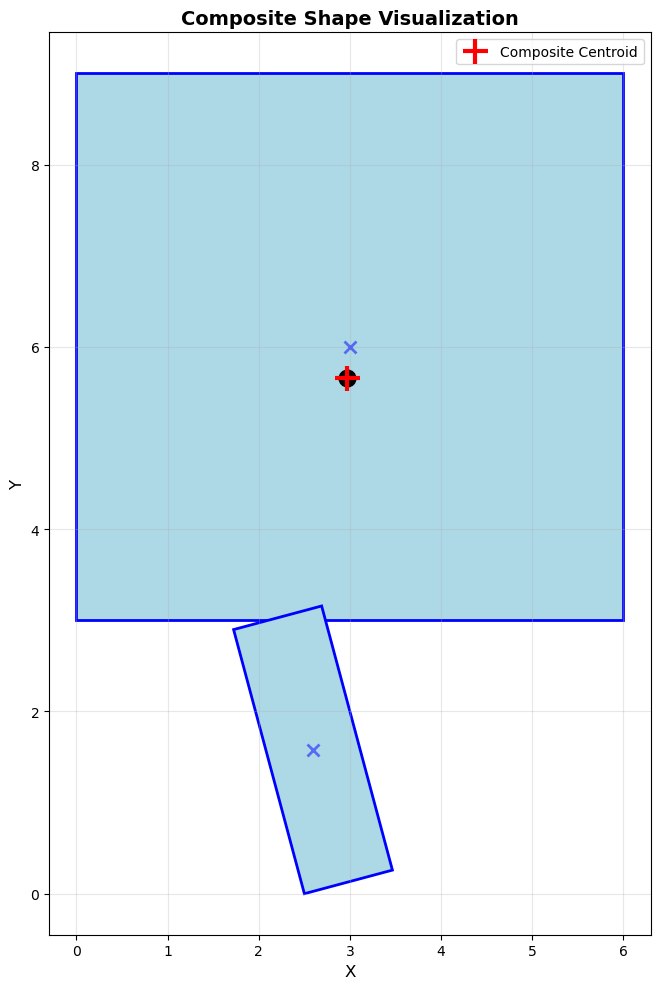

In [56]:
# Example 1: T-beam with rotation
composite = CompositeShape()
print("\n*** Example 1: T-Beam with Rotated Web ***")
composite.add_shape(Rectangle_(x=0, y=3, width=6, height=6))  # Top flange
composite.add_shape(Rectangle_(x=2.5, y=0, width=1, height=3, angle=15))  # Rotated web

composite.calculate_composite_properties()
composite.print_properties()
composite.visualize()



*** Example 2: Rectangle with Rotated Cutout ***

INDIVIDUAL SHAPE PROPERTIES

Shape 1: Rectangle [ADDED]
  Position: (0.00, 0.00)
  Rotation: 0.0°
  Area: 20.0000
  Centroid: (2.5000, 2.0000)
  Ixx (local centroidal): 26.6667
  Iyy (local centroidal): 41.6667

Shape 2: Rectangle (Hollow) [SUBTRACTED]
  Position: (1.50, 1.00)
  Rotation: 45.0°
  Area: 4.0000
  Centroid: (1.5000, 2.4142)
  Ixx (local centroidal): 1.3333
  Iyy (local centroidal): 1.3333

COMPOSITE SHAPE PROPERTIES
  Total Area: 16.0000
  Composite Centroid: (2.7500, 1.8964)
  Ixx (about composite centroid): 24.4755
  Iyy (about composite centroid): 35.3333



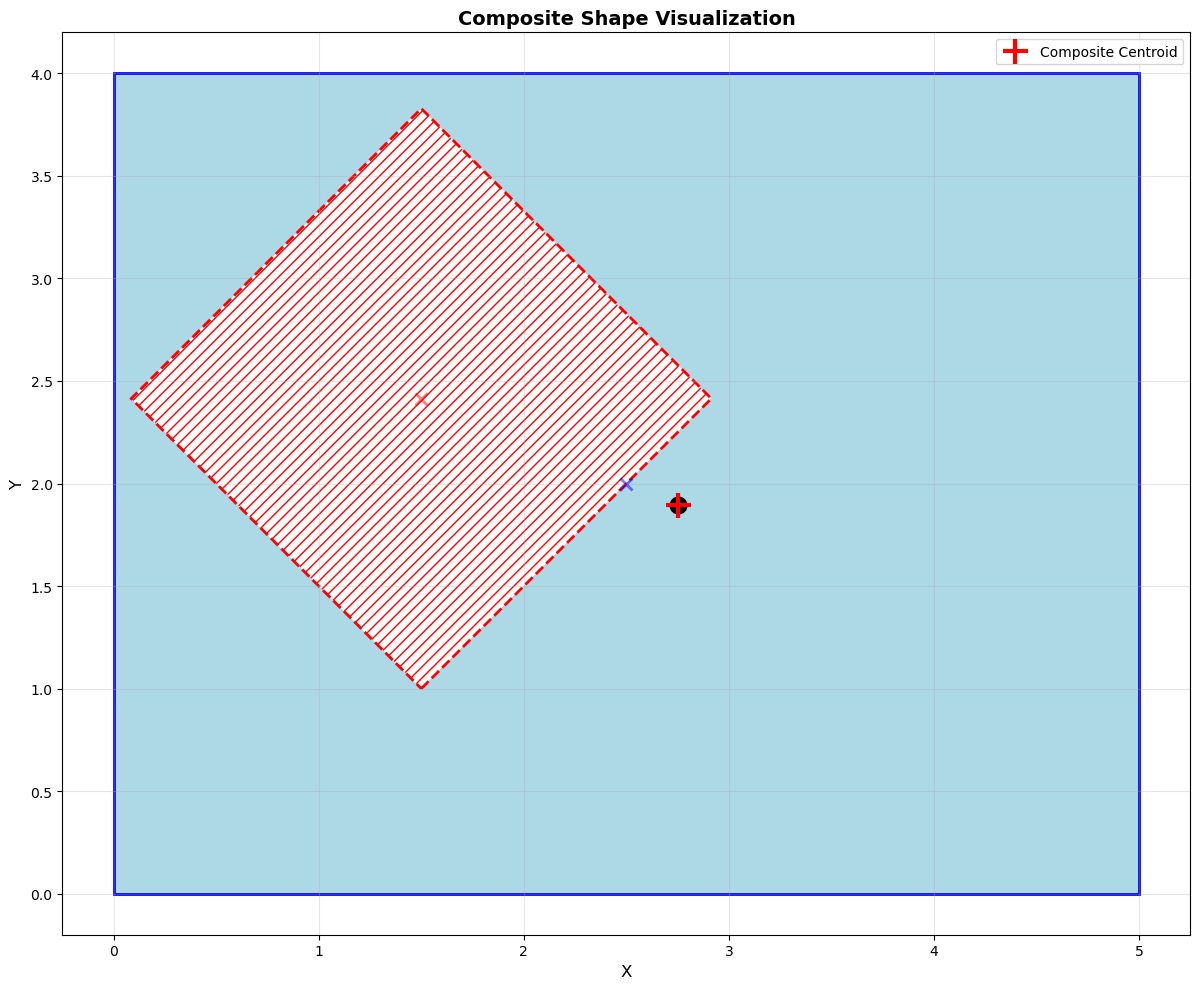

In [57]:

# Example 2: Hollow rectangle with rotated cutout
print("\n*** Example 2: Rectangle with Rotated Cutout ***")
composite2 = CompositeShape()
composite2.add_shape(Rectangle_(x=0, y=0, width=5, height=4))  # Outer rectangle
composite2.add_shape(Rectangle_(x=1.5, y=1, width=2, height=2, is_hollow=True, angle=45))  # Rotated cutout

composite2.calculate_composite_properties()
composite2.print_properties()
composite2.visualize()



*** Example 3: Complex Composite with Rotations ***

INDIVIDUAL SHAPE PROPERTIES

Shape 1: Rectangle [ADDED]
  Position: (0.00, 0.00)
  Rotation: 0.0°
  Area: 13200.0000
  Centroid: (55.0000, 60.0000)
  Ixx (local centroidal): 15840000.0000
  Iyy (local centroidal): 13310000.0000

Shape 2: Triangle (Hollow) [SUBTRACTED]
  Position: (110.00, 40.00)
  Rotation: 90.0°
  Area: 1200.0000
  Centroid: (90.0000, 60.0000)
  Ixx (local centroidal): 106666.6667
  Iyy (local centroidal): 240000.0000

Shape 3: Semicircle [ADDED]
  Position: (110.00, 60.00)
  Rotation: -90.0°
  Area: 5654.8668
  Centroid: (135.4648, 60.0000)
  Ixx (local centroidal): 5089380.0988
  Iyy (local centroidal): 1423008.0000

COMPOSITE SHAPE PROPERTIES
  Total Area: 17654.8668
  Composite Centroid: (78.3940, 60.0000)
  Ixx (about composite centroid): 20822713.4321
  Iyy (about composite centroid): 39973781.0182



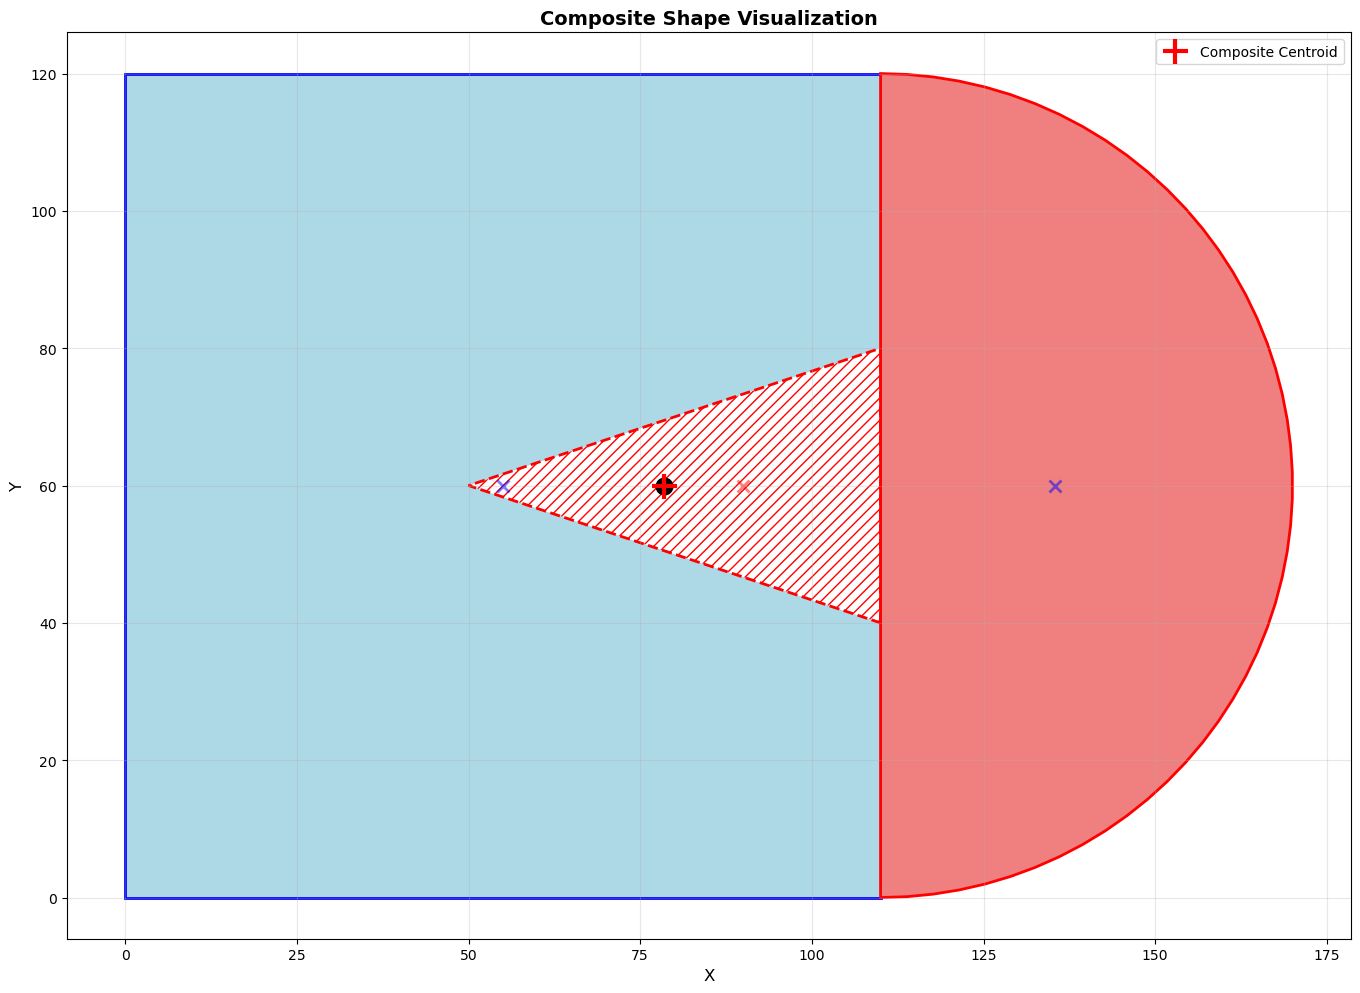

In [4]:
# Example 3: Complex composite with rotated shapes
print("\n*** Example 3: Complex Composite with Rotations ***")
composite3 = CompositeShape()
composite3.add_shape(Rectangle_(x=0, y=0, height=120, width=110))
composite3.add_shape(Triangle(x=110, y=40, height=60,  base=40, is_hollow=True, angle=90))
composite3.add_shape(Semicircle(x=110, y=60, radius=60, angle=-90))

composite3.calculate_composite_properties()
composite3.print_properties()
composite3.visualize()